In [1]:
from arpes.all import *
%matplotlib inline

C:\Users\hellbrue\Documents\Repositories\pyarpes\arpes\config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2022-09-21_11-46-30.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
from arpes.io import example_data
from arpes.utilities.conversion import convert_to_kspace
from arpes.fits.utilities import broadcast_model
from arpes.fits.fit_models import AffineBroadenedFD, QuadraticModel
import matplotlib.pyplot as plt


def load_energy_corrected():
    fmap = example_data.map.spectrum
    cut = fmap.sum("theta").sel(
        eV=slice(-0.2, 0.1), phi=slice(-0.25, 0.3)
    )

    results = broadcast_model(AffineBroadenedFD, cut, "phi")
    edge = QuadraticModel().guess_fit(results.F.p("fd_center")).eval(x=fmap.phi)
    return fmap.G.shift_by(edge, "eV")

energy_corrected = load_energy_corrected()

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/96 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


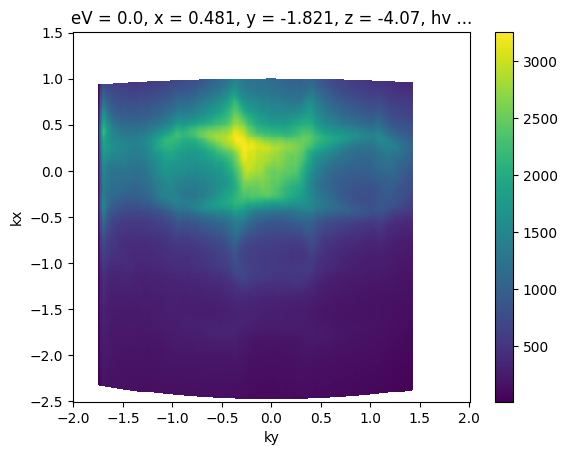

In [3]:
import numpy as np
convert_to_kspace(
    energy_corrected.S.fermi_surface, # just convert the Fermi surface
    kx=np.linspace(-2.5, 1.5, 400),   # along -2.5 <= kx < 1.5 (inv ang.)
                                      #  with 400 steps
    ky=np.linspace(-2, 2, 400),       # as above, with -2 <= ky < 2
).S.plot()

{'alpha': 0.0,
 'beta': 0.0,
 'chi': -1.4851355,
 'phi': 0.05671,
 'psi': 0.0,
 'theta': -0.01392}


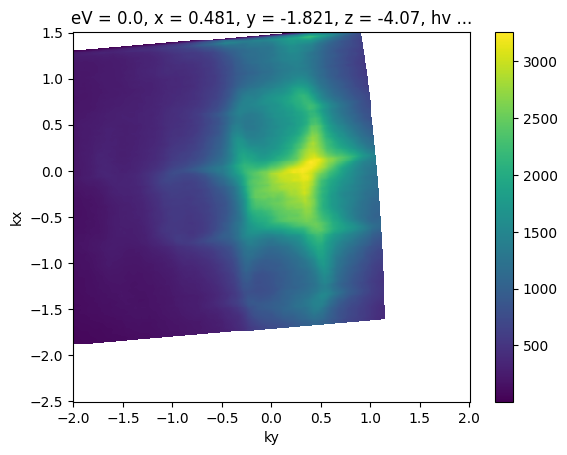

In [4]:
# Let's look at what the assigned values were, for some reference
import pprint # pretty print
pprint.pprint(energy_corrected.S.offsets)

example_fs = energy_corrected.S.fermi_surface.copy(deep=True)
example_fs.S.apply_offsets({
    "phi": 0.,    # controls the offset along the analyzer center axis
    "theta": 0.0,
    "chi": 0.,    # sample rotation, controls kx-ky plane orientation
    "alpha": 0.,
    "psi": 0.,
})
convert_to_kspace(
    example_fs,
    kx=np.linspace(-2.5, 1.5, 400),
    ky=np.linspace(-2, 2, 400),
).S.plot()

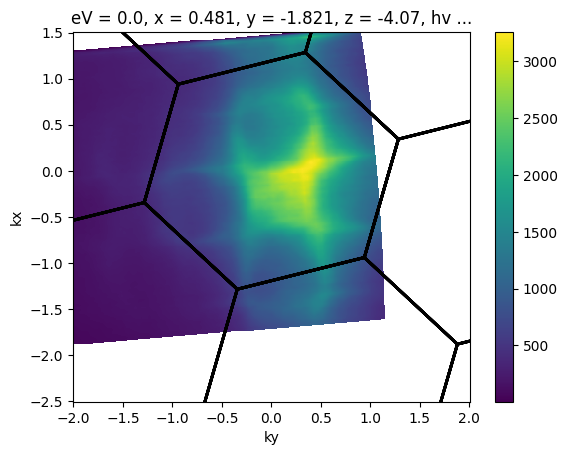

In [5]:
from arpes.plotting.bz import overplot_standard

convert_to_kspace(
    example_fs,
    kx=np.linspace(-2.5, 1.5, 400),
    ky=np.linspace(-2, 2, 400),
).S.plot()

# plot a graphene BZ over the data... obviously silly here
# to demonstrate parameters we'll rotate 30 degrees and plot several higher BZs.
bz_plotter = overplot_standard("ws2", repeat=([-2,2],[-2,2]), rotate=np.pi / 12)
bz_plotter(plt.gca())

In [6]:
import numpy as np
kcube = convert_to_kspace(
    energy_corrected,
    kx=np.linspace(-2.5, 1.5, 400),
    ky=np.linspace(-2, 2, 400),
)

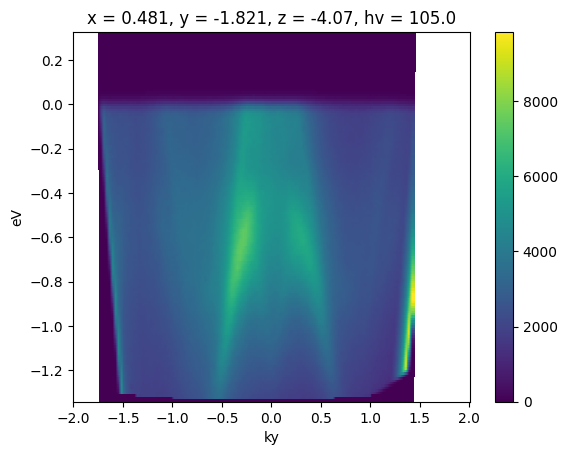

In [7]:
kcube.sel(kx=slice(-0.02, 0.02)).mean("kx").S.plot()

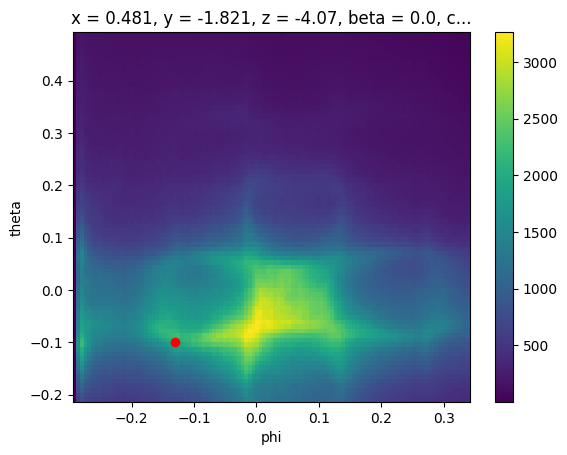

In [8]:
energy_corrected.S.fermi_surface.S.plot()
plt.gca().scatter([-0.13], [-0.1], color="red")

# we will determine where this point goes
test_point = {
    "phi": -0.13,
    "theta": -0.1,
    "eV": 0.01,
}

In [9]:
from arpes.utilities.conversion.forward import convert_coordinate_forward

k_test_point = convert_coordinate_forward(energy_corrected, test_point)

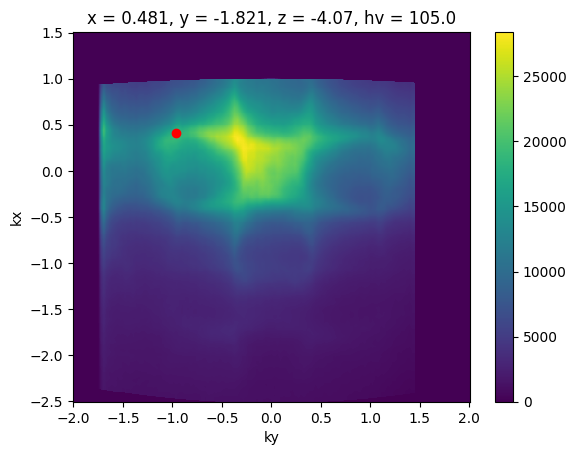

In [10]:
kcube.sel(eV=slice(-0.05,0.05)).sum("eV").S.plot()
plt.gca().scatter([k_test_point["ky"]], [k_test_point["kx"]], color="red")

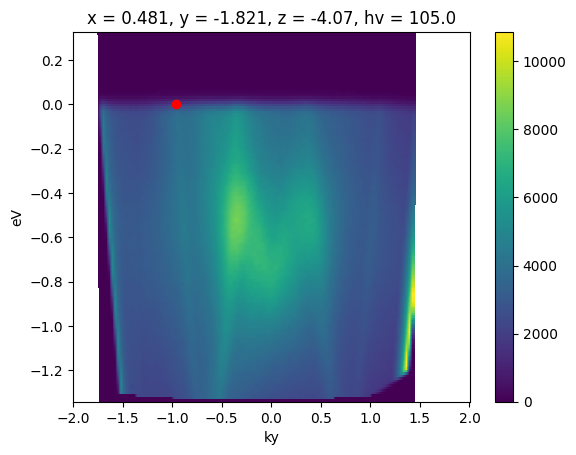

In [11]:
ky_slice = convert_to_kspace(
    energy_corrected,
    kx=np.linspace(k_test_point["kx"] - 0.02, k_test_point["kx"] + 0.02, 20),
    ky=np.linspace(-2, 2, 800)
).mean("kx").S.plot()

plt.gca().scatter([k_test_point["ky"]], [0.], color="red")

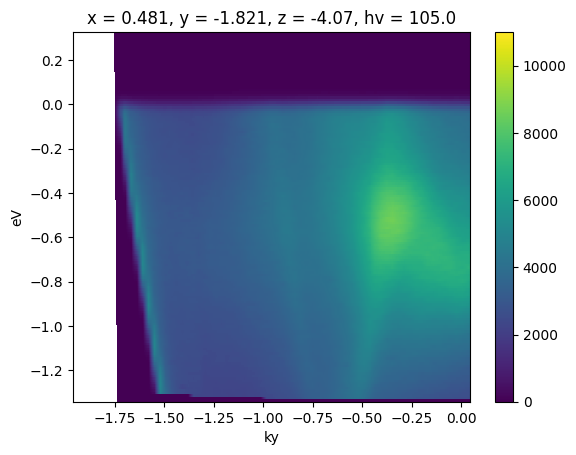

In [12]:
from arpes.utilities.conversion.forward import convert_through_angular_point

convert_through_angular_point(
    energy_corrected,
    test_point,
    {"ky": np.linspace(-1, 1, 400)}, # give the cut which has +/- 1 inv ang
                                    # in `kx` around our point of interest
    {"kx": np.linspace(-0.02, 0.02, 10)}, # take 20 milli inv ang. perpendicular
).S.plot(vmax=11000) # set vmax for better comparison to above

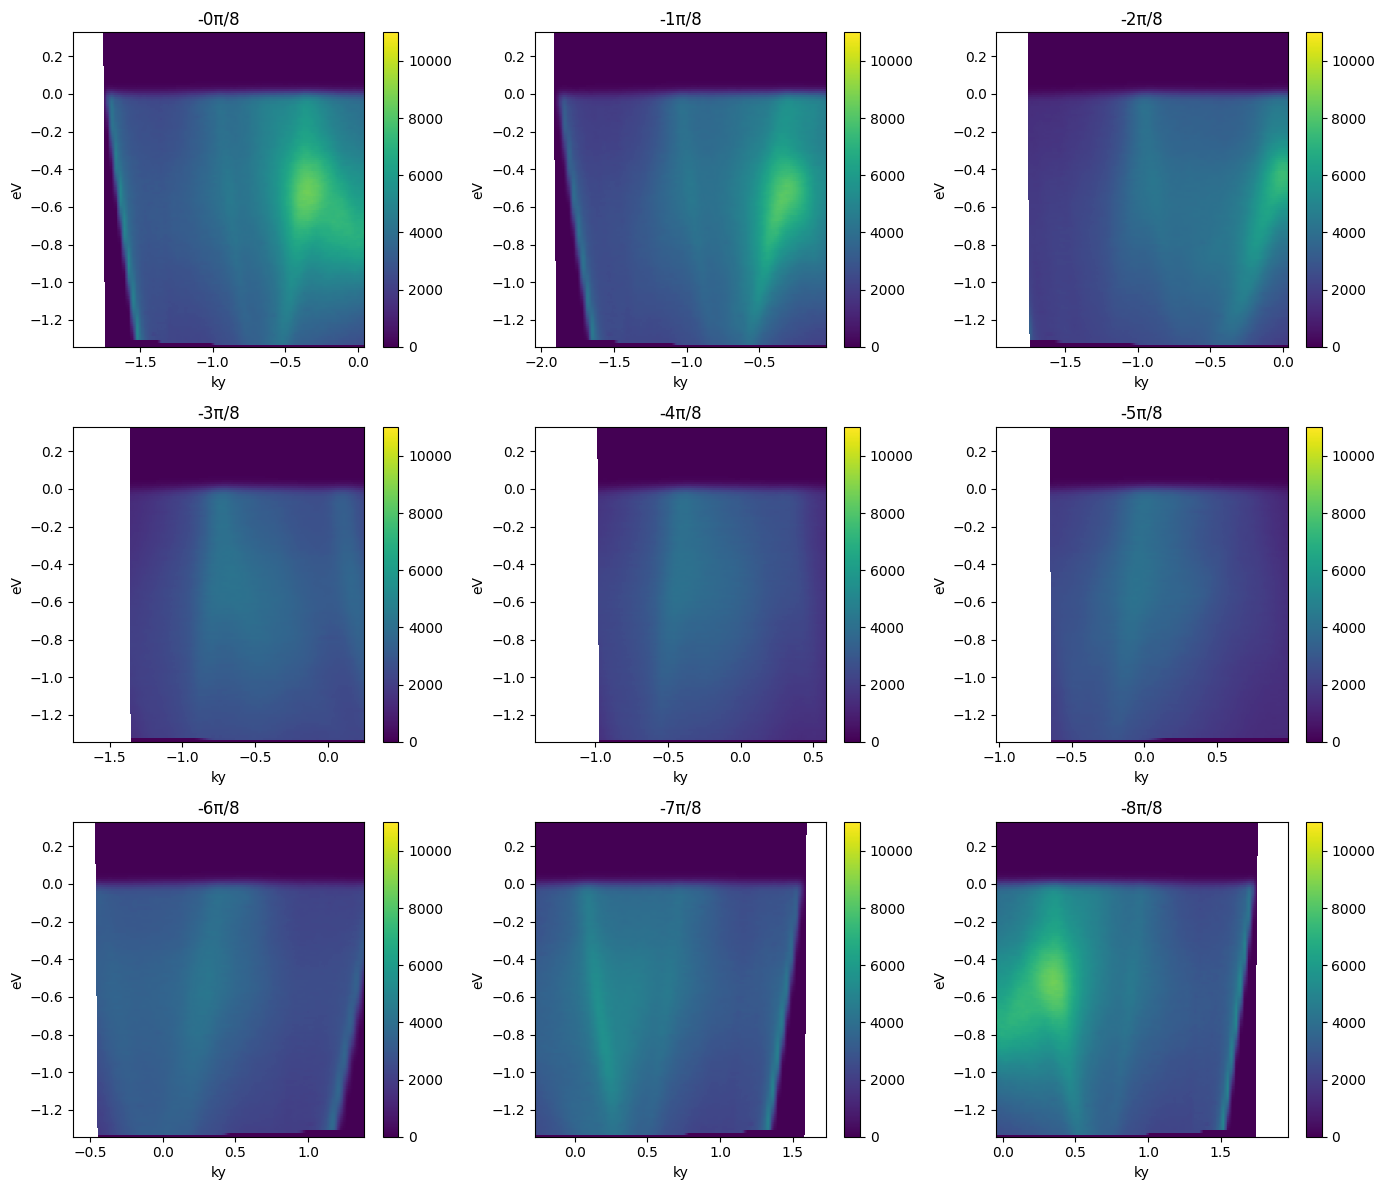

In [15]:
from arpes.config import use_tex
use_tex(False) # just to be safe, in case you don't have LaTeX installed

fig, ax = plt.subplots(3, 3, figsize=(14, 12))

for inc in range(9):
    with energy_corrected.S.with_rotation_offset(-inc*np.pi / 8):
        convert_through_angular_point(
            energy_corrected,
            test_point,
            {"ky": np.linspace(-1, 1, 400)},
            {"kx": np.linspace(-0.02, 0.02, 10)},
        ).S.plot(vmax=11000, ax=ax.ravel()[inc])
        ax.ravel()[inc].set_title(f"-{inc}π/8")

plt.tight_layout()

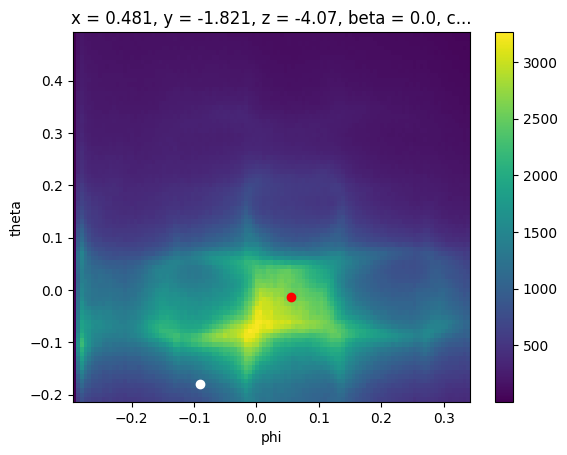

In [18]:
energy_corrected.S.fermi_surface.S.plot()
plt.gca().scatter([0.055], [-0.013], color="red")
plt.gca().scatter([-0.09], [-0.18], color="white")


# we will get the cut through these two points
p1 = {
    "phi": 0.055,
    "theta": -0.013,
    "eV": 0.01,
}
p2 = {
    "phi": -0.09,
    "theta": -0.18,
    "eV": 0.01,
}

In [19]:
from arpes.analysis.moire import angle_between_vectors

kp1 = convert_coordinate_forward(energy_corrected, p1)
kp2 = convert_coordinate_forward(energy_corrected, p2)

def to_vec(p):
    return np.array([p["kx"], p["ky"]])

print(kp1)
print(kp2)
print(to_vec(kp1))
print(to_vec(kp2))
delta = to_vec(kp2) - to_vec(kp1)
ang = np.arctan2(delta[1], delta[0])
print(ang)

with energy_corrected.S.with_rotation_offset(-ang):
    kp1 = convert_coordinate_forward(energy_corrected, p1)
    kp2 = convert_coordinate_forward(energy_corrected, p2)

    print(kp1, kp2)

    delta = to_vec(kp2) - to_vec(kp1)
    print(np.arctan2(delta[1], delta[0]))

{'kx': -0.027115300158778416, 'ky': -0.022266815310293564}
{'kx': 0.9003614742745181, 'ky': -0.7552690787473395}
[-0.0271153  -0.02226682]
[ 0.90036147 -0.75526908]
-0.6688097857188012
{'kx': -0.007721360764839022, 'ky': -0.03447721360764837} {'kx': 1.174384649167258, 'ky': -0.03447721360764837}
0.0


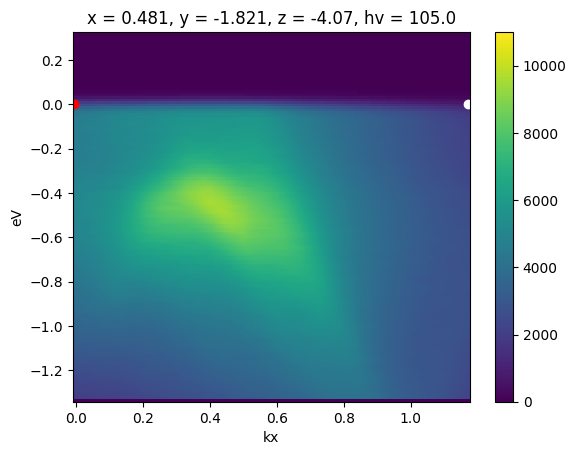

In [20]:
from arpes.utilities.conversion.forward import convert_through_angular_pair

convert_through_angular_pair(
    energy_corrected,
    p1, p2,
    {"kx": np.linspace(-0, 0, 400)}, # interpolate from p1 to p2 only
    {"ky": np.linspace(-0.02, 0.02, 10)}, # take 20 milli inv ang. perpendicular
).S.plot(vmax=11000)

# plotted only for legibility
plt.gca().scatter([-0.007], [0.], color="red")
plt.gca().scatter([1.17], [0.], color="white")


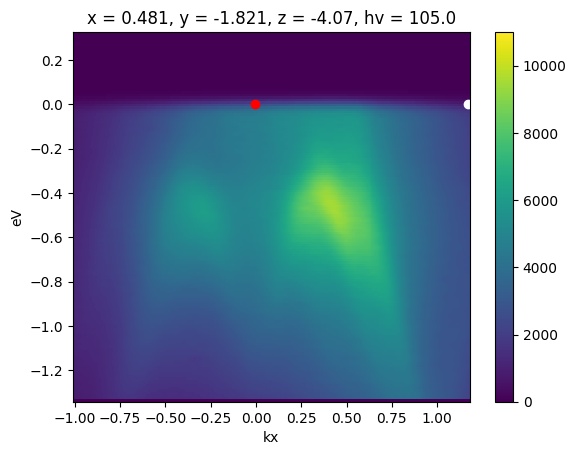

In [21]:
from arpes.utilities.conversion.forward import convert_through_angular_pair

convert_through_angular_pair(
    energy_corrected,
    p1, p2,
    {"kx": np.linspace(-1, 0, 400)}, # interpolate 1 inv ang. further left
    {"ky": np.linspace(-0.02, 0.02, 10)}, # take 20 milli inv ang. perpendicular
).S.plot(vmax=11000)

# plotted only for legibility
plt.gca().scatter([-0.007], [0.], color="red")
plt.gca().scatter([1.17], [0.], color="white")